In [40]:
struct Global
    nv          ::Int    #boundary point
    jx          ::Int    #cell number
    inter       ::Int #split point of two material
    kindProblem ::Int #kind of problem
    tt          ::Float64      #total time
    cfl         ::Float64     # cfl
end

struct Const
    Y0 ::Float64
    ρ0 ::Float64
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end

struct BoundCon
    ρ ::Float64
    u ::Float64
    p ::Float64
    sxx::Float64
end


In [83]:
#module Initial
#export state1, problem1

    

function initial()
    

    nv = 3
    jx = 200
    tt = 1.5e-4
    cfl = 0.5
    lx =1.0
    inter=0
    kindProblem=1
    dx=lx/jx


    ρ2=893.0
    u2=10.0
    p2=1.e5
    sxx2=0
    
    
    ρ1=893.0
    u1=0.0
    p1=1.e5
    sxx1=0.0
    global    rB=BoundCon(ρ2,u2,p2,sxx2)
    global    lB=BoundCon(ρ1,u1,p1,sxx1)
    
    global   con = Const(9e2,893.0,2.0,4.5e5,394.0,1.49)
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))

    x = [(i+0.5-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1 
        uo[i,1] = ρ1
        uo[i,2] = u1
        uo[i,3] = p1
        uo[i,4] = sxx1
        u[i,:]=UoTou(uo[i,:],con)
    end    

    global   problem=Global(nv,jx,inter,kindProblem, tt,cfl)
    return uo,u,x
end

#PyPlot.plot(x,uo[:,1:4])
#end

initial (generic function with 1 method)

$$ 1Pa = 1N/m^2 = 1 kg/(m\cdot s^2) = 10^{-11} g/(cm \cdot \mu s^2)$$ 

$$ 1 m/s = 10^{-4} cm/\mu s$$
$$ 1kg/m^3 = 10^{-3} g/cm^3$$


$$f(\eta) = \frac{(\eta-1)(\eta-\Gamma_0(\eta-1)/2)}{(\eta-s_0(\eta-1))^2}$$
$$f'(\eta) = \frac{\eta+(s_0-\Gamma_0)(\eta-1)}{(\eta-s_0(\eta-1))^3}$$

In [84]:
function fη(ρ::Float64,c::Const=con)
    η = ρ/c.ρ0
    fη=(η-1.0)*(η-c.Γ0*(η-1.0)/2.0)/(η-c.s0*(η-1))^2
end

function fηη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fηη=(η+(c.s0-c.Γ0)*(η-1))/(η-c.s0*(η-1))^3
end


fηη (generic function with 1 method)

Mie-Gr\"uneisen equation of state
$$e =\frac{p-\rho_0a_0^2f(\eta)}{\rho_0\Gamma_0}$$

$$p = \rho_0a_0^2f(\eta)+\rho_0\Gamma_0e$$

In [85]:
function PToe(ρ::Float64,p::Float64,con::Const)
    c=con
    ei = (p-c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function EToP(ρ::Float64,ei::Float64,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei+c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

EToP (generic function with 1 method)

$$ \begin{aligned}
    & \rho = uo[1]\\
    & u  = uo[2]\\
    & p =uo[3]\\
    & s_{xx}=uo[4]
     \end{aligned} \hspace{0.3cm}
    \begin{aligned}
    &U[1]=\rho\\
    &U[2]=\rho u\\
    &U[3]=\rho E\\
    &U[4]=s_{xx}\\
    \end{aligned}
$$

$$ e=E/\rho-\frac{1}{2}u^2$$


In [86]:
"""
 from  the primitive variables uo to  conservative variables U
"""
function UoTou(uo::Array{Float64,1},con::Const)
    u = zeros(Float64, 4)
    u[1]=uo[1]
    u[2]=uo[2]*uo[1]
    ei = PToe(uo[1],uo[3],con)
    u[3]=(ei+0.5uo[2]^2)*uo[1]
    u[4]=uo[4]
    return u
end

UoTou

In [87]:
"""
 from conservative variables U  to  the primitive variables uo
"""
function UToUo(u::Array{Float64,1},con::Const)
    uo = zeros(Float64, 4)
    uo[1]=u[1]
    uo[2]=u[2]/u[1]
    ei=u[3]/uo[1]-0.5uo[2]^2
    p = EToP(uo[1],ei,con)
    uo[3]=p
    uo[4]=u[4]
    return uo
end  

UToUo

$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}+\frac{4}{3}\frac{\mu}{\rho}}$$
$$ a^2= a_0^2 f'(\eta)+\frac{p}{\rho^2}\rho_0\Gamma_0$$

In [88]:
function sound(uo::Array{Float64,1},con::Const=con)::Float64
    a0  = con.a0
    ρ0  = con.ρ0
    Γ0  = con.Γ0
    μ   = con.μ
    ρ   = uo[1]
    uu  = uo[2]
    p   = uo[3]
    sxx = uo[4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
    c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
    return c
end


function Cfl(uo::Array{Float64,2},x::Array{Float64,1},problem::Global=problem,con::Const=con)
    nv=problem.nv
    jx=problem.jx
    sf=problem.cfl
    
    dx1=0
    dxmin=x[nv+2]-x[nv+1]
    for i in nv+2:jx+2nv+1
        dx  = x[i]-x[i-1]
        c = sound(uo[i,:],con)
        dxmin = min(dx,dxmin)
        dx1=dxmin/c
    end
    dt=sf*dx1
    return dt
end    


Cfl (generic function with 3 methods)

In [98]:
function TimeSolve()
    uo,u,x=initial()
    tt= problem.tt
    
    t=0
   # while t<tt
        dt=Cfl(uo,x)
        if t+dt>tt
           dt = tt-t
        end
        t += dt
        uo,x=R_K3(dt,uo,x)
        #println(t,dt)
        PyPlot.plot(x,uo[:,1])
   # end
end

TimeSolve (generic function with 1 method)

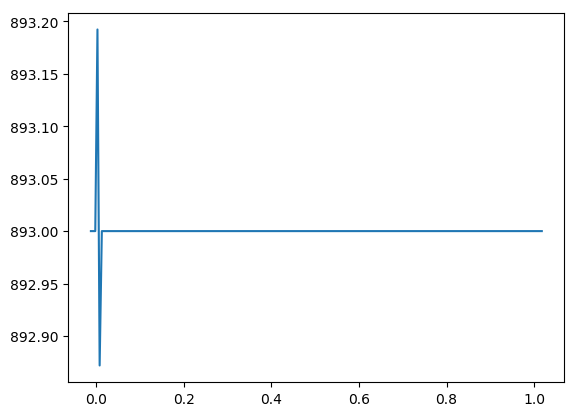

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa26bf31f28>

In [99]:
using PyPlot
TimeSolve()

In [48]:
function WENO3(u::Array{Float64,1})
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        IS0 = (u[i] - u[i-1])^2
        IS1 = (u[i+1] - u[i])^2
        
        c0 = 2.0/3
        c1 = 1.0/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3*u[i]-u[i+1])/2
        
        c0 = 1.0/3
        c1 = 2.0/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        b0 = α0/(α0+α1)
        b1 = α1/(α0+α1)
        
        uL[i] = β0*(u[i]+u[i-1])/2+β1*(u[i]-u[i+1])/2
    end
    return uL,uR
end
        

WENO3 (generic function with 1 method)

In [49]:
function Yυ(s::Float64,con::Const=con)
    Y0 = con.Y0
    f=0
    if s <= 2Y0/3
        f = s
    elseif s > 2Y0/3
        f = 2Y0/3
    else
        f = -2Y0/3
    end
end

Yυ (generic function with 2 methods)

In [50]:
function HLLCEPNew(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},problem::Global=problem,con::Const=con)
    Y0 = con.Y0
    ρ0 = con.ρ0
    Γ0 = con.Γ0
    nv = problem.nv
    jx = problem.nv
    μ  = con.μ
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1+nv:I-nv
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:])
        eL = PToe(ρL, pL, con)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:])
        eR = PToe(ρR, pR, con)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL-cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4.0μ/3*log(ρLstar/ρL) +sxxL
        #if (abs(sxxL) < 2Y0/3 && abs(tmp) >= 2Y0/3)
        if abs(tmp) >= 2Y0/3 
            if tmp > 2Y0/3
                hsxxL = 2Y0/3
                hρL  = ρL*exp(-Y0/(2μ)+3sxxL/(4μ))
            elseif tmp < -2/3*Y0
                hsxxL = -2Y0/3
                hρL  = ρL*exp(Y0/(2μ)+3sxxL/(4μ))
            end
            t    = ρL*hρL/(hρL-ρL)
            c0   = 1/(ρ0*Γ0)
            c1   = a0^2/Γ0
            hpL   = (2t*(c1*fη(hρL,con)+eL)-(σL+hsxxL))/(2t*c0-1)
            hσL = -hpL + hsxxL
            if ρLstar > ρL
               huuL = uuL -sqrt((σL-hσL)/t)
            else
               huuL = uuL +sqrt((σL-hσL)/t)
            end
            ρL   = hρL
            uuL  = huuL
            pL   = hpL
            sxxL = hsxxL
            σL   = hσL
            ue[1] = ρL
            ue[2] = uuL
            ue[3] = pL
            ue[4] = sxxL
            cL = sound(ue,con)
        end
        
        tmp = -4.0μ/3*log(ρRstar/ρR) +sxxR
        #if (abs(sxxR) < 2Y0/3 && abs(tmp) >= 2Y0/3) 
        if abs(tmp) >= 2Y0/3
            if tmp > 2Y0/3
               hsxxR = 2Y0/3
               hρR  = ρR*exp(-Y0/(2μ)+3sxxR/(4μ))
            elseif tmp < -2/3*Y0
               hsxxR = -2Y0/3
               hρR  = ρR*exp(Y0/(2μ)+3sxxR/(4μ))
            end
            t    = ρR*hρR/(hρR-ρR)
            c0   = 1/(ρ0*Γ0)
            c1   = a0^2/Γ0
           hpR   = (2t*(c1*fη(hρR,con)+eR)-(σR+hsxxR))/(2t*c0-1)
           hσR = hpR +hsxxR
            if ρRstar > ρR
               huuR = uuR +sqrt((σR-hσR)/t)
            else
               huuR = uuR -sqrt((σR-hσR)/t)
            end
            ρR = hρR
            uuR = huuR
            pR = hpR
            sxxR = hsxxR
            σR = hσR
            ue[1] = ρR
            ue[2] = uuR
            ue[3] = pR
            ue[4] = sxxR
            cR = sound(ue,con)
        end
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4μ/3*log(ρLstar/ρL) +sxxL
        if tmp >= 2Y0/3
            sxxLstar = 2Y0/3
        elseif tmp <= -2Y0/3
            sxxLstar  = -2Y0/3
        else
            sxxLstar = tmp
        end
        
        tmp = -4μ/3*log(ρRstar/ρR) +sxxR
        
        if tmp >= 2Y0/3
            sxxRstar = 2Y0/3
        elseif tmp <= -2Y0/3
            sxxRstar  = -2Y0/3
        else
            sxxRstar = tmp
        end
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
        if s_star > u[i] 
            f[i,1] = 0
            f[i,2] = pLstar-sxxLstar
            f[i,3] = (pLstar-sxxLstar)*s_star
            f[i,4] = -4μ/3*s_star
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pRstar-sxxRstar
            f[i,3] = (pRstar-sxxRstar)*s_star
            f[i,4] = -4μ/3*s_star
            uuh[i] = s_star
        end
    end
    return f, uuh
end

HLLCEPNew (generic function with 3 methods)

In [51]:
function HLLCEP(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},problem::Global=problem,con::Const=con)
    Y0 = con.Y0
    ρ0 = con.ρ0
    Γ0 = con.Γ0
    μ  = con.μ
    nv = problem.nv
    jx = problem.jx
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1+nv:I-nv
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:])
        eL = PToe(ρL, pL, con)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:])
        eR = PToe(ρR, pR, con)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL-cL, uuR+cR)
        s_barstar = (sxxR-sxxL)/(ρL*(sL-uuL)-ρR*(sR-uuR))
        sxxL_bar = sxxL+ρL*(sL-uuL)*s_barstar
        sxxR_bar = sxxR+ρR*(sR-uuR)*s_barstar
        
        sxxL_star = Yυ(sxxL_bar)
        sxxR_star = Yυ(sxxR_bar)
        
        sxL_star = (sxxL_star-sxxL)/(ρL*(sL-uuL))
        sxR_star = (sxxL_star-sxxL)/(ρL*(sL-uuL))
        
        
        s_star = (pR - pL + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        pL_star = pL+ρL*(sL-uuL)*(s_star + sxL_star - uuL)
        pR_star = pR+ρR*(sR-uuR)*(s_star + sxR_star - uuR)
        
        if s_star > u[i]
            f[i,1] = 0
            f[i,2] = pL_star-sxxL_star
            f[i,3] = (pL_star-sxxL_star)*s_star
            f[i,4] = -4μ/3*s_star 
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pR_star-sxxR_star
            f[i,3] = (pR_star-sxxR_star)*s_star
            f[i,4] = -4μ/3*s_star 
            uuh[i] = s_star
        end
    end
    return f, uuh
end
        

HLLCEP (generic function with 3 methods)

In [52]:
function Space(uo::Array{Float64,2},problem::Global=problem,con::Const=con)
    kind_split = 1
    nv = problem.nv
   # h = zeros(Float64,)
   
    I,J = size(uo)
    uL=zeros(Float64,(I,J))
    uR=zeros(Float64,(I,J))
    f=zeros(Float64,(I,J))
    uuh=zeros(Float64,I)
     if kind_split==1
        for i in 1:J
            uL[:,i],uR[:,i] = WENO3(uo[:,i])
        end
        h,uuh = HLLCEP(uo[:,2],uL,uR)
     end
    for i in nv+1:I-2nv-1
        f[i,:]= h[i,:]-h[i-1,:]
    end
    return f,uuh
end
        

Space (generic function with 3 methods)

In [53]:
function Bound(uo::Array{Float64,2},lB::BoundCon=lB,rB::BoundCon=rB,problem::Global=problem)
    kind_prb= problem.kindProblem
    nv = problem.nv
    jx = problem.jx
    ρ0 = con.ρ0
    if kind_prb == 1
        for i in 1:nv
            uo[i,1] = ρ0
            uo[i,2] = uo[1,2]
            uo[i,3] = 0.0
            uo[i,4] = 0.0
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = 0    
        end
    end
    return uo
end

Bound (generic function with 4 methods)

In [82]:
function R_K(dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},lB::BoundCon=lB,rB::BoundCon=rB,problem::Global=problem,con::Const=con,order::Int8=3)
    if order==3
       uo,x = R_K3(dt,uo,x)
    end
    return uo,x
end
function R_K3(dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},lB::BoundCon=lB,rB::BoundCon=rB,problem::Global=problem,con::Const=con)
    μ = con.μ
    I,J=size(uo)
    dx = zeros(Float64,I)
    uo = Bound(uo)
    udx= zeros(Float64,(I,J))

    for i in 2:I
        dx[i] =x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I    
        u[i,1:4]=UoTou(uo[i,1:4],con)
        udx[i,:]=u[i,:]*dx[i]
    end 
#****************1**********************    
    f,uuh=Space(uo)   
    #x1 = zeros(Float64,I) 
    
    udx1 = zeros(Float64,(I,J))
    x1   = zeros(Float64,I)
    for i in 1:I
        x1[i] = x[i] + dt*uuh[i]
    end
    
    for i in 2:I
        dx[i] =x1[i]-x1[i-1]
    end
    dx[1] =dx[2]
    for i in 1:I
        ρ1 = u[i,1]
        udx1[i,1:4] = udx[i,1:4] -dt*f[i,1:4]
        u[i,1:3] = udx1[i,1:3]/dx[i]
        u[i,4]=-4μ/3*log(u[i,1]/ρ1) + u[i,4]
        u[i,4]= Yυ(u[i,4])
        uo[i,:] = UToUo(u[i,:],con)
    end
    
    uo = Bound(uo)
# #***************2***********************    
    for i in 1:I
        u[i,:] = UoTou(uo[i,:],con)
    end
    
    f,uuh = Space(uo)
    
    udx2 = zeros(Float64,(I,J))
    x2   = zeros(Float64,I)
    for i in 1:I
        x2[i] = 3/4*x[i] +1/4*x1[i]+1/4*dt*uuh[i]
    end
    for i in 2:I
        dx[i] =x2[i]-x2[i-1]
    end
    dx[1] =dx[2]
        ρ1 = u[i,1]
        udx2[i,1:4] = 3/4*udx[i,1:4]+1/4*udx1[i,1:4] -dt*f[i,1:4]
        u[i,1:3] = udx2[i,1:3]/dx[i]
        u[i,4]=-4μ/3*log(u[i,1]/ρ1) + u[i,4]
        u[i,4]= Yυ(u[i,4])
        uo[i,:] = UToUo(u[i,:],con)
    end    
    uo = Bound(uo)
#  #***************3**********************   
#     for i in 1:I
#         u[i,:] = UoTou(uo[i,:],con)
#     end
    
#      f,uuh = Space(uo)
    
#     for i in 1:I
#         x[i] = 1/3*x[i] +2/3*x2[i]+1/4*dt*uuh[i]
#         ρ1 = u[i,1]
#         udx2[i,1:4] = 1/3*udx[i,1:4]+2/3*udx2[i,1:4] -2/3*dt*f[i,1:4]
#         u[i,1:3] = udx[i,1:3]/dx[i]
#         u[i,4]=-4μ/3*log(u[i,1]/ρ1) + u[i,4]
#         u[i,4]= Yυ(u[i,4])
#         uo[i,:] = UToUo(u[i,:],con)
#     end
    uo = Bound(uo)
    
    return uo,x
end

    
    
    

R_K3 (generic function with 5 methods)

In [81]:
TimeSolve()

LoadError: MethodError: no method matching R_K(::Float64, ::Array{Float64,2}, ::Array{Float64,1}, ::Int64)
Closest candidates are:
  R_K(::Float64, ::Array{Float64,2}, ::Array{Float64,1}, !Matched::BoundCon, !Matched::BoundCon, !Matched::Global, !Matched::Const, !Matched::Int8) at In[78]:2
  R_K(::Float64, ::Array{Float64,2}, ::Array{Float64,1}, !Matched::BoundCon, !Matched::BoundCon, !Matched::Global, !Matched::Const) at In[78]:2
  R_K(::Float64, ::Array{Float64,2}, ::Array{Float64,1}, !Matched::BoundCon, !Matched::BoundCon, !Matched::Global) at In[78]:2
  ...

In [53]:
I,J=size(u)


LoadError: MethodError: no method matching length(::Const)
Closest candidates are:
  length(!Matched::Core.SimpleVector) at essentials.jl:571
  length(!Matched::Base.MethodList) at reflection.jl:728
  length(!Matched::Core.MethodTable) at reflection.jl:802
  ...

In [55]:
@time a,b,c,d=initial()


  0.000069 seconds (433 allocations: 61.156 KiB)


(Global(3, 200, 0, 1, 0.00015, 0.5, [893.0 0.0 50000.0 0.0; 893.0 0.0 50000.0 0.0; … ; 893.0 0.0 50000.0 0.0; 893.0 0.0 50000.0 0.0], [893.0 0.0 100000.0 0.0; 893.0 0.0 100000.0 0.0; … ; 893.0 0.0 100000.0 0.0; 893.0 0.0 100000.0 0.0], [-0.0125, -0.0075, -0.0025, 0.0025, 0.0075, 0.0125, 0.0175, 0.0225, 0.0275, 0.0325  …  0.9725, 0.9775, 0.9825, 0.9875, 0.9925, 0.9975, 1.0025, 1.0075, 1.0125, 1.0175]), Const(900.0, 893.0, 2.0, 450000.0, 394.0, 1.49), BoundCon(893.0, 0.0, 100000.0, 0.0), BoundCon(893.0, 10.0, 100000.0, 0.0))

In [1]:
struct st
    a::Integer
    b::Float64
end

In [9]:
c =st(1,2.0)
a=c.a
a=2
c.a =a 

LoadError: type st is immutable

In [52]:
function t1()
t=0
while (t<10)
     t += 1
    println(t)
end
   # return t
end

t1 (generic function with 1 method)

In [15]:
using Pkg
Pkg.add("Rebugger")

LoadError: The following package names could not be resolved:
 * Rebugger (not found in project, manifest or registry)
Please specify by known `name=uuid`.

In [111]:
function add2(c,a=a)
    return c+a*2
end

function add1(c,a=a)
    return add2(c)
end

add1 (generic function with 2 methods)

In [114]:
function add3()
  global  a=2
    add1(2)
end

add3 (generic function with 1 method)

In [115]:
add3()

6

In [20]:
text()

4
